# Self Driving Car Engineer Nanodegree

## Project: Build a Vehicle Detection Pipeline

In this project, the goal is to write a software pipeline to detect vehicles in a video (start with the test_video.mp4 and later implement on full project_video.mp4).

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

Here are links to the labeled data for [vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip) and [non-vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip) examples to train your classifier.  These example images come from a combination of the [GTI vehicle image database](http://www.gti.ssr.upm.es/data/Vehicle_database.html), the [KITTI vision benchmark suite](http://www.cvlibs.net/datasets/kitti/), and examples extracted from the project video itself.   You are welcome and encouraged to take advantage of the recently released [Udacity labeled dataset](https://github.com/udacity/self-driving-car/tree/master/annotations) to augment your training data.

---

## Step 0: Preparation

In [283]:
import glob
import time
import cv2
import pickle
import numpy as np
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML

plt.style.use('fivethirtyeight')
%matplotlib inline

In [444]:
###################################################################
# HELPER FUNCTIONS
###################################################################

# SAVE DATA
# Pickle data
"""
path: path to save the data to
data: data that should be saved
"""
def save_data(data, path):
    with open(path, mode="wb") as f:
        print("Saving data to: {}".format(path))
        pickle.dump(data, f)
        print("Done.")

# LOAD DATA
# Load pickled data
"""
path: path to load data from
return: data that was loaded
"""
def load_data(path):
    with open(path, mode="rb") as f:
        print("Loading data from: {}". format(path))
        data = pickle.load(f)
        print("Done.")
    return data

# PRINT INFORMATION
# Print some information of the dataset
"""
data_frame: pandas DataFrame object that contains the data
name: name of the dataset
"""
def print_dataset_info(data, name="Dataset"):
    classes = np.unique(data["label"])
    percentage_car = data[data["label"] == "car"].shape[0] / data.shape[0] * 100
    print("-"*50)
    print(name)
    print("-"*50)
    print("Number of classes = {}".format(classes.shape[0]))
    print("Number of samples = {}".format(data.shape[0]))
    print("Percentage of car images: {:.2f}%".format(percentage_car))
    print("-"*50)

    # Show distribution of labels in the dataset
    class_list = pd.DataFrame(data={"class": classes})
    class_list["amount"] = [sum(data["label"]==c) for c in classes]
    display(class_list.sort_values("amount", ascending=False))
   
# FORMAT DATASET
# Brings dataset into desired format for further processing which is 
# a pandas DataFrame with columns: frame, xmax, ymax, xmin, ymin, label
"""
target: single path to a csv file or dict of key=label value=[path]
store_path: path to save or load data 
match_map: dict to map columns of csv files to columns of desired Data Frame key=target_column value=source_column
return: pandas DataFrame of the data with columns: frame, xmax, ymax, xmin, ymin
"""
def format_dataset(target , store_path, match_map=None):
    if not os.path.isfile(store_path):
        # Create dict to fill data into
        data = {"frame": [], "xmax": [], "ymax": [], "xmin": [], "ymin": [], "label": []}
        if isinstance(target, dict):
            # Loop over each key value pair in the target dict
            for label, paths in target.items():
                # Loop over each path in the paths list
                for path in paths:
                    # Get all image (.png and .jpg) files
                    frames = glob.glob(os.path.join(path, "*.png"))
                    frames.extend(glob.glob(os.path.join(path, "*.jpg")))
                    frames = [os.path.normpath(p) for p in frames]
                    # Add data to the dict
                    data["frame"].extend(frames)
                    data["label"].extend([label]*len(frames))
                    data["xmax"].extend([None]*len(frames))
                    data["ymax"].extend([None]*len(frames))
                    data["xmin"].extend([None]*len(frames))
                    data["ymin"].extend([None]*len(frames))
                    
        elif isinstance(target, str):
            # Check whether passed file is .csv
            if os.path.splitext(target)[1] == ".csv":
                # Read in data from csv
                source = pd.read_csv(target)
                # Remap csv columns to desired output
                for column in data:
                    match = match_map[column]
                    if not match == None:
                        data[column] = source[match]
                    else:
                        data[column] = [None]*source.shape[0]
                # Get path to the frames
                data_path = os.path.dirname(target)
                # Add path information to frame
                data["frame"] = [os.path.normpath(os.path.join(data_path, file)) for file in data["frame"]]
            else:
                print("Pass .csv file or dict")
        
        # Create DataFrame
        data = pd.DataFrame(data=data)
        # Save data to pickle
        save_data(data, store_path)
    else:
        # Load data from pickle
        data = load_data(store_path)
    
    return data

# GET DATA
# Composes data from multiple sources into one
"""
datasets: list that describes which data to get and can be 1: standard, 2: udacity_1, and 3: udacity_2
return: composed dataset
"""
def get_data(data_sets=[1, 2, 3]):
    standard_data_paths = {"non-car": ["non-vehicles/non-vehicles/Extras/", "non-vehicles/non-vehicles/GTI/"], 
                          "car": ["vehicles/vehicles/GTI_Far/", "vehicles/vehicles/GTI_Left/", 
                                      "vehicles/vehicles/GTI_Right/", "vehicles/vehicles/GTI_MiddleClose/",
                                      "vehicles/vehicles/KITTI_extracted/"]}
    # Additional data: Read in dataset 1 from Udacity dataset available at
    # https://github.com/udacity/self-driving-car/tree/master/annotations
    udacity_1_data_path = "object-detection-crowdai/object-detection-crowdai/labels.csv"
    udacity_1_match_map = {"frame": "frame", "xmax": "xmax", "ymax": "ymax", "xmin": "xmin", "ymin": "ymin", "label": "label"}
    # Additional data: Read in dataset 2 from Udacity dataset available at
    # https://github.com/udacity/self-driving-car/tree/master/annotations
    # The labels.csv of this dataset has to be adapted before reading it:
    # * add column headers
    # * change delimiter from " " to ","
    # Otherwise the traffic light labels will lead to problems as the number of columns is inconsistent
    udacity_2_data_path = "object-dataset/object-dataset/labels.csv"
    udacity_2_match_map = {"frame": "frame", "xmax": "xmax", "ymax": "ymax", "xmin": "xmin", "ymin": "ymin", "label": "label"}
    # Dict to handle dataset mappings and their store paths
    data_sources = {1: [standard_data_paths, "standard_data.p"], 
                    2: [udacity_1_data_path, "udacity_1_data.p", udacity_1_match_map],
                    3: [udacity_2_data_path, "udacity_2_data.p", udacity_2_match_map]}
    data = pd.DataFrame()
    # Read in data
    data = data.append([format_dataset(*data_sources[key]) for key in data_sets])
    # Make all labels lowercase
    data["label"] = data["label"].str.lower()
    
    return data

# MAP LABELS
# Map existing labels to desired labels
"""
data: dataset
mapping: list of tuples (target_label, list_of_labels_to_convert) to change labels 
return: dataset with rearranged labels
"""
def map_labels(data, mapping):
    # Loop through the mapping items
    for target, labels in mapping:
        if not labels == None: 
            # Loop through the labels that should be converted
            for label in labels:
                # Change current label to desired one
                data[data["label"] == label] = target
        # If labels == None map every remaining label to target
        else: 
            # Get list of all used targets and remove the current target
            used_targets = list(np.array(mapping)[:,0])
            used_targets.remove(target)
            # Change all labels that were not mapped yet
            indices = [all(hit_list) for hit_list in zip(*[data["label"] != used_target for used_target in used_targets])]
            data["label"][indices] = target
    return data

# GENERATOR
# Generator to read image data in batches and operate memory efficient
"""
data: the whole dataset DataFrame
batch_size: number of images to load into memory at once
img_size: size to resize images to
yield: shuffled batch of data
"""
def generator(data, label_binarizer, batch_size=128, img_size=(64,64)):
    num_samples = data.shape[0]
    # Loop forever so the generator never terminates
    while 1:
        # Shuffle the data
        shuffle(data)
        # Loop over the whole dataset with stepsize of batch
        for offset in range(0, num_samples, batch_size):
            batch_samples = data[offset:offset+batch_size]
            
            images = []
            labels = label_binarizer.transform(batch_samples["label"])
            # Loop over the batch
            for batch_sample in batch_samples:
                # Read in image and convert to RGB
                img = cv2.cvtColor(cv2.imread(batch_sample["frame"]), cv2.COLOR_BGR2RGB)
                # Check whether image has to be cropped
                xmin = 0 if batch_sample["xmin"] == None else batch_sample["xmin"]
                ymin = 0 if batch_sample["ymin"] == None else batch_sample["ymin"]
                xmax = img.shape[1] if batch_sample["xmax"] == None else batch_sample["xmax"]
                ymax = img.shape[0] if batch_sample["ymax"] == None else batch_sample["ymax"]
                img = img[ymin:ymax, xmin:xmax]
                # Resize image to desired size
                img = cv2.resize(img, img_size)
                # Add image to list    
                images.append(img)
            # Convert lists to numpy arrays
            X = np.array(images)
            y = no.array(labels)
            
            yield shuffle(X, y)

# PLOT IMAGES            
# Plot images in a grid
"""
imgs: images that should be shown
columns: number of columns of the grid
labels: labels of the images that are shown
"""
def plot_images(imgs, columns, labels=None):
    plt.figure(figsize=(15,15))
    num_examples = len(imgs)
    for key, img in enumerate(imgs):
        plt.subplot(num_examples//columns, columns, key+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(img)
        if labels is not None:
            plt.gca().set_title("{}".format(labels[key]), fontsize=10)
    plt.tight_layout()
    plt.show()
    
# BOUNDING BOXES
# Draw bounding boxes on an image
"""
img: image to draw on
bboxes: list of tuples with coordinates for top left and bottom right corner
color: color of the bounding boxes as RGB tuple
thick: thickness of the line of the bounding boxes
return: copy of the image with drawn bounding boxes
"""
def draw_boxes(img, bboxes, color=(255, 0, 0), thick=6):
    imcopy = np.copy(img)
    
    for box in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

# PLOT COLOR SPACE IN 3D
# Compute 3D scatter plot to visualize image pixels in color space
"""
img: the image which is to analyze 
colors_rgb: colors for the pixel values
axis_labels: list of label names for the axes
axis_limits: tuple with lower and upper limits of the axes
return: Axes3D object
"""
def plot3d(img, colors_rgb, axis_labels=list("RGB"), axis_limits=((0,255), (0,255), (0,255))):
    # Create figure and 3D axes
    fig = plt.figure(figsize=(8,8))
    ax = Axes3D(fig)
    
    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])
    
    # Set axis labels and sizes
    ax.tick_params(axis="both", which="major", labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)
    
    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        img[:,:,0].ravel(),
        img[:,:,1].ravel(),
        img[:,:,2].ravel(),
        c=colors_rgb.reshape((-1,3)), edgecolors='none')
    
    return ax

In [445]:
# Read in data
data = get_data([1])
print_dataset_info(data, name="Composed Dataset")
# Map labels to match "car" and "non-car" only
data_mapped = map_labels(data, mapping=[("car", ["truck"]), ("non-car", None)])
print_dataset_info(data_mapped, name="Mapped Dataset")

Loading data from: standard_data.p
Done.
--------------------------------------------------
Composed Dataset
--------------------------------------------------
Number of classes = 2
Number of samples = 17760
Percentage of car images: 49.50%
--------------------------------------------------


,class,amount
1,non-car,8968
0,car,8792


--------------------------------------------------
Mapped Dataset
--------------------------------------------------
Number of classes = 2
Number of samples = 17760
Percentage of car images: 49.50%
--------------------------------------------------


,class,amount
1,non-car,8968
0,car,8792


In [442]:
# Initialize binarizer
label_binarizer = LabelBinarizer()
label_binarizer.fit(data_mapped["label"])
CLASSES = label_binarizer.classes_

In [ ]:
# TODO: Split training and test data
# TODO: Check what the next step should be and continue implementing considering the next few cells
train_generator = generator()
test_generator = generator()

In [64]:
# Take data and split it into train and test set
data = standard_data
X_train, X_test, y_train, y_test = train_test_split(data["features"], data["labels"], test_size=0.2, random_state=42)

# Number of samples in dataset
n_samples = data["features"].shape[0]

# Number of training examples
n_train = X_train.shape[0]

# Number of validation examples
#n_validation = X_valid.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train.shape[1:4]

# How many unique classes/labels there are in the dataset.
n_classes = np.unique(y_train).shape[0]

print("Number of samples is dataset = {}".format(n_samples))
print("Number of training examples = {}".format(n_train))
#print("Number of validation examples = {}".format(n_validation))
print("Number of testing examples = {}".format(n_test))
print("Image data shape = {}".format(image_shape))
print("Number of classes = {}".format(n_classes))

Number of training examples = 14208
Number of testing examples = 3552
Image data shape = (64, 64, 3)
Number of classes = 2


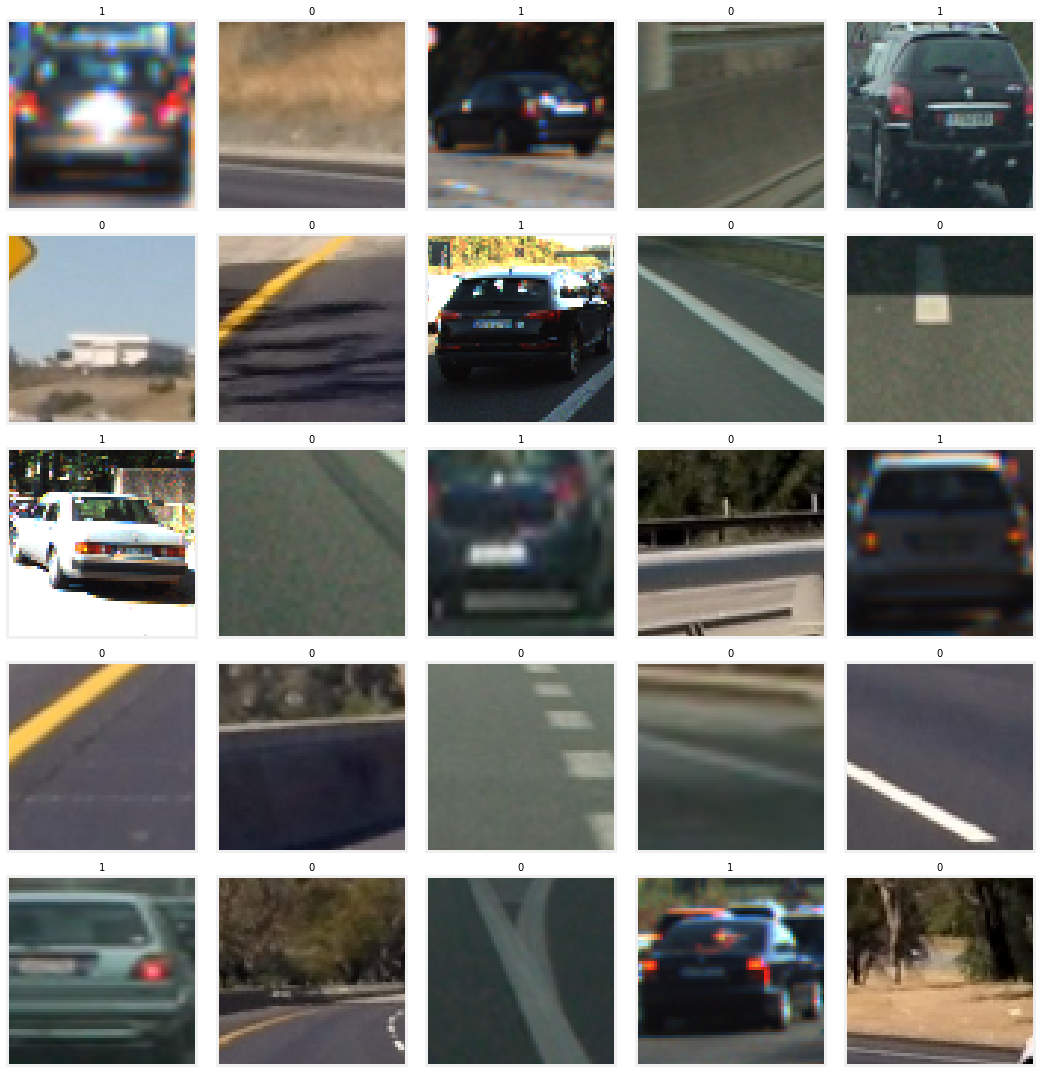

In [65]:
columns = 5

# Pick random images 
indices = np.random.choice(n_train, size=25, replace=False)
plot_images(X_train[indices], columns, labels=y_train[indices])

In [ ]:
###################################################################
# FEATURE EXTRACTION
###################################################################

# Dictionary for color transform mapping on default RGB images
RGB_COLOR_TRANSFORMS = {"HSV": cv2.COLOR_RGB2HSV, "HLS": cv2.COLOR_RGB2HLS,
                       "LUV": cv2.RGB2LUV, "YUV": cv2.RGB2YUV, "YCrCb": cv2.COLOR_RGB2YCrCb}
BGR_COLOR_TRANSFORMS = {"RGB": cv2.COLOR_BGR2RGB, "HSV": cv2.COLOR_BGR2HSV, "HLS": cv2.COLOR_BGR2HLS,
                       "LUV": cv2.BGR2LUV, "YUV": cv2.BGR2YUV, "YCrCb": cv2.COLOR_BGR2YCrCb}
# TODO: Maybe add more colorspaces

# COLOR HISTOGRAM
# Compute color histogram features
def color_hist(img, nbins=32, bins_range=(0, 256)):
"""
img: image to compute the color histogram on
nbins: number of bins for the histogram
bins_range: a tuple with the lower and upper range of the bins
return: histogram for each channel of the image, array with centers of the 
        bins and feature vector of the histograms
"""
    channel_histograms = []
    # Compute the histogram of each channel separately
    for channel in range(img.shape[-1]):
        hist = np.histogram(img[:,:,channel], bins=nbins, range=bins_range)
        channel_histograms.append(hist)
    
    # Generating bin centers
    bin_edges = channel_histograms[0][1]
    bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges)-1])/2
    
    # Concatenate the histograms into a single feature vector
    # TODO: concatenate histogram features
    # TODO: retunr channel histograms, bin centers and feature vector
    return channel_histograms

# SPATIAL BINNING
# Compute spatial color features
def bin_spatial(img, color_space=None, size=(32,32), color_transforms=RGB_COLOR_TRANSFORMS):
"""
img: image that should be converted into spatial features
color_space: color space to take the features of
size: size of spatial feature area
return: spatial feature vector
"""
    # Convert image to new color space
    if color_space != None:
        feature_img = cv2.cvtColor(img, color_transforms[color_space])
    else:
        feature_img = np.copy(img)
    # Create spatial color feature vector
    features = cv2.resize(feature_img, size).ravel()
    
    return features
    
# HOG FEATURES
# Compute histogram of oriented gradients (hog) features
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
"""
img: image where features should be extracted
orient: number of different gradient orientations to consider
pix_per_cell: size of the cells
cell_per_block: number of cells for each block
vis: should the hog feature visualization be returned
feature_vec: features should be returned as vector
return: features or features and an image with a hog feature visualization
"""
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                 cells_per_block=(cell_per_block, cell_per_block), visualize=True, 
                                 feature_vector=feature_vec)
        return features, hog_image
    else:
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                      cells_per_block=(cell_per_block, cell_per_block), visualize=False, feature_vector=feature_vec)
        return features

# COMBINE
# Extract features from a list of images 
def extract_features(imgs, cspace=None, spatial_size=(32, 32), hist_bins=32, hist_range=(0,256), 
                     color_transforms=RGB_COLOR_TRANSFORMS):
"""
imgs: list of images to extract features on
cspace: colorspace on which to operate
spatial_size: size for the spatial binning
hist_bins: number of bins for color histograms
hist_range: range of the histograms
return: list of feature vectors
"""
    # Create a list to append feature vectors to
    features = []
    
    # Transform colorspace if necessary
    for img in imgs:
        if cspace != None:
            feature_img = cv2.cvtColor(img, color_transforms[cspace])
        else:
            feature_img = np.copy(img)
        # Apply spatial binning
        bin_features = bin_spatial(feature_img, size=spatial_size)
        # Apply color histogram
        hist_features = color_hist(feature_img, nbins=hist_bins, bins_range=hist_range)
        # Append the feature vector to the list
        features.append(np.concatenate((bin_features, hist_features), axis=0))
    
    return features

# NORMALIZE
# 
def normalize_features(features):
"""
features: list of feature vectors
return: normalized list of feature vectors
"""
    # Fit a per column scaler
    X_scaler = StandardScaler().fit(features)
    # Apply the scaler to the features
    scaled_X = X_scaler.transform(features)
    
    return scaled_X

In [ ]:
# Example Code for some of the Functions
# Read a color image
img = cv2.imread("000275.png")

# Select a small fraction of pixels to plot by subsampling it
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)),
                       interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting
# Plot and show
plot3d(img_small_RGB, img_small_rgb)
plt.show()

plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
plt.show()

# DATA EXPLORATION
images = glob.glob('*.jpeg')
cars = []
notcars = []

for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)
        
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = img.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
car_ind = np.random.randint(0, len(cars))

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)


### TODO: Tweak these parameters and see how the results change.
color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 12  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, None] # Min and max in y to search in slide_window()


In [ ]:
###################################################################
# CLASSIFIER
###################################################################

# LINEAR SVM
# Build a linear SVM classifier
def build_linear_svm(train, parameters):
"""
train: tuple of data for training of the classifier
parameters: dictionary of parameters for grid search
return: classifier and best parameters
"""
    svr = svm.SVC()
    # Creates the grid of possible parameter combinations
    clf = grid_search.GridSearchCV(svr, parameters)
    # Tries all parameter combinations and returns the fitted classifier
    clf.fit(*train)
    return clf, clf.best_params_

# TODO: Implement other classifiers

In [ ]:
# Color Classify Parameters:
Spatial = 50
Histbin = 32
# --> 97.5% Test Accuracy

# HOG Classify Parameters:
Colorspace = 'HLS'
Orient = 12
Pix_per_cell = 8
Cell_per_block = 2
Hog_channel = "ALL"
# --> 99% Test Accuracy

In [ ]:
###################################################################
# OBJECT DETECTION
###################################################################

# SLIDING WINDOW
# Slide a window over the image that takes those sub samples for classification
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                 xy_window=(64,64), xy_overlap=(0.5,0.5)):
"""
img: image that should be scanned for objects
x_start_stop: start and stop positions for the scanning area in x direction
y_start_stop: start and stop positions for the scanning area in y direction
xy_window: dimensions of the sliding window
xy_overlap: overlap of windows in x and y direction
return: list of tuples with window start and end positions
"""
    # Set start stop positions if not defined
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    it y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
        
    # Compute the span of the region to be searched
    x_span = np.int(x_start_stop[1] - x_start_stop[0])
    y_span = np.int(y_start_stop[1] - y_start_stop[0])
    
    # Compute the number of pixels per step in x|y
    step_pix_x = xy_window[0] * (1 - xy_overlap[0])
    step_pix_y = xy_window[1] * (1 - xy_overlap[1])
    
    # Compute the number of windows in x|y
    x_buffer = np.int(xy_window[0] * xy_overlap[0])
    y_buffer = np.int(xy_window[1] * xy_overlap[1])
    n_windows_x = np.int((x_span - x_buffer) / step_pix_x)
    n_windows_y = np.int((y_span - y_buffer) / step_pix_y)
    
    # Initialize a list to append window positions
    window_list = []
    
    # Loop through finding x and y window positions
    for step_y in range(n_windows_y):
        for step_x in range(n_windows_x):
            # Calculate each window position
            start_x = np.int(step_x * step_pix_x + x_start_stop[0])
            start_y = np.int(step_y * step_pix_y + y_start_stop[0])
            end_x = np.int(start_x + xy_window[0])
            end_y = np.int(start_y + xy_window[1])
            # Append position to list
            window_list.append(((start_x, start_y), (end_x, end_y)))
    return window_list

# HOG SUBSAMPLING WINDOW SEARCH
# Extract features using hog sub-sampling and make predictions
def find_cars(img, y_start_stop, x_start_stop, scale, svc, X_scaler, window=64, orient, pix_per_cell, cell_per_block, 
              cells_per_step=2, spatial_size, hist_bins, color=(255, 0, 0), thick=6, cspace=None, color_transforms=RGB_COLOR_TRANSFORMS):
"""
img:
y_start_stop:
x_start_stop:
scale:
svc:
X_scaler:
window:
orient:
pix_per_cell:
cell_per_block:
cells_per_step: instead of overlap define how many cells to step
spatial_size:
hist_bins:
color: color of the bounding box lines
thick: thickness of the bounding box lines
cspace:
color_transforms: 
return:
"""
    draw_img = np.copy(img)
    # TODO: Check whether following line is necessary and if better to put in if-statement,
    # e.g. if image already is 0 to 1 scale
    img = img.astype(np.float32)/255
    
    # TODO: check whether values of start stop are None and adapt accordingly
    img_search = img[y_start_stop[0]:y_start_stop[1], x_start_stop[0]:x_start_stop[1], :]
    if cspace != None:
        feature_img = cv2.cvtColor(img_search, color_transforms[cspace])
    else:
        feature_img = img_search
        
    if scale != 1:
        img_shape = feature_img.shape
        feature_img = cv2.resize(feature_img, (np.int(img_shape[1]/scale), np.int(img_shape[0]/scale)))
    
    # TODO: Check if split to channels is necessary
    ch1 = feature_img[:,:,0]
    ch2 = feature_img[:,:,1]
    ch3 = feature_img[:,:,2]
    
    # Define blocks and steps
    n_blocks_x = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1 # TODO: Understand why it is like this and what celss, blocks and windows are
    n_blocks_y = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1
    n_feat_per_block = orient * np.square(cell_per_block) # TODO: Check if np.square is the right function
    n_blocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    n_steps_x = (n_blocks_x - n_blocks_per_window) // cells_per_step
    n_steps_y = (n_blocks_y - n_blocks_per_window) // cells_per_step
    
    # Compute individual channel hog features
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for step_x in range(n_steps_x):
        for step_y in range(n_steps_y):
            pos_y = step_y * cells_per_step
            pos_x = step_x * cells_per_step
            
            # Extract hog for this patch
            # TODO: Understand why it works like this and what n_blocks_per_windo does here
            hog_feat1 = hog1[pos_y:pos_y + n_blocks_per_window, pos_x:pos_x + n_blocks_per_window].ravel() 
            hog_feat2 = hog2[pos_y:pos_y + n_blocks_per_window, pos_x:pos_x + n_blocks_per_window].ravel()
            hog_feat3 = hog3[pos_y:pos_y + n_blocks_per_window, pos_x:pos_x + n_blocks_per_window].ravel()
            
            hog_features = np.hstack((hog1, hog2, hog3)) # TODO: Check if vstack works and if not why not
            
            x_left = pos_x * pix_per_cell
            y_top = pos_y * pix_per_cell
            
            # Extract the image patch
            sub_img = cv2.resize(feature_img[y_top:y_top+window, x_left:x_left+window])
            
            # Get color features
            spatial_features = bin_spatial(sub_img, size=spatial_size)
            hist_features = color_hist(sub_img, nbins=hist_bins)
            
            # Scale features and make a prediction
            # TODO: Check if vstack works
            features = X_scaler.transform(np.hstacl((spatial_features, hist_features, hog_features)).reshape(1, -1))
            prediction = svc.predict(features)
            
            # If prediction was car (1)
            if prediction == 1:
                box_left = np.int(x_left * scale)
                box_top = np.int(y_top * scale)
                win_draw = np.int(window * scale)
                cv2.rectangle(draw_img, (box_left, y_top+y_start_stop[0]), 
                              (box_left+win_draw, y_top+win_draw+y_start_stop[0]), color, thick)
            
            return draw_img

# SEARCH OVER ALL WINDOWS
# Extract features from a single image window
def single_img_features(img, color_space=None, spatial_size=(32,32), hist_bins=32, orient=9, pix_per_cell=8,
                        cell_per_block=2, hog_channel=0, spatial_feat=True, hist_feat=True, hog_feat=True, 
                        color_transforms=RGB_COLOR_TRANSFORMS):
"""
img: 
color_space: 
spatial_size: 
hist_bins: 
orient: 
pix_per_cell: 
cell_per_block: 
hog_channel: 
spatial_feat: 
hist_feat: 
hog_feat: 
color_transforms: 
return: 
"""
    # Empty list to receive features
    features = []
    # Apply color conversion
    if color_space != None:
        feature_img = cv2.cvtColor(img, color_transforms[color_space])
    else:
        feature_img = np.copy(img)
    # Compute spatial features
    if spatial_feat:
        spatial_features = bin_spatial(feature_img, size=spatial_size)
        features.append(spatial_features)
    # Compute histogram features
    if hist_feat:
        hist_features = color_hist(feature_img, nbins=hist_bins)
        features.append(hist_features)
    # Compute hog features
    if hog_feat:
        if hog_channel == "ALL":
            hog_features = []
            for channel in range(feature_img.shape[2]):
                hog_features.extend(get_hog_features(feature_img[:,:,channel], orient, pix_per_cell, cell_per_block,
                                                    vis=False, feature_vec=True))
        else:
            hog_features = get_hog_features(feature_img[:,:,hog_channel], orient, pix_per_cell, cell_per_block, 
                                            vis=False, feature_vec=True)
        features.appen(hog_features)
    
    return np.concatenate(features)
        
# OBJECT SEARCH
# Search in windows for target objects
def search_windows(img, windows, clf, scaler, color_space=None, window_size=(64,64), spatial_size=(32,32), hist_bins=32, 
                   hist_range(0, 256), orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0, spatial_feat=True, 
                   hist_feat=True, hog_feat=True, color_transforms=RGB_COLOR_TRANSFORMS):
"""
img:
windows:
clf:
scaler:
color_space:
window_size:
spatial_size:
hist_bins:
hist_range:
orient:
pix_per_cell:
cell_per_block:
hog_channel:
spatial_feat:
hist_feat:
hog_feat:
color_transforms:
return:
"""
    # Create an empty list to receive positive detection windows
    on_windows = []
    # Iterate over all windows in the list
    for window in windows:
        # Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0], window[1][0]], window_size) # TODO: Check whether window_size is necessary, what it does and why not just set it to (64,64)
        # Extract features for that window
        features = single_img_features(test_img, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins,
                                      orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                      hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat,
                                      hog_feat=hog_feat, color_transforms=color_transforms)
        # Scale extracted features
        features = scaler.transform(np.array(features).reshape(1, -1)) # TODO: Check if vstack works
        # Predict the class
        prediction = clf.predict(features)
        # If prediction is car (1) save window
        if prediction == 1:
            on_windows.append(window)
        
        return on_windows
    
# HEATMAP
# Add heat values to heatmap for pixels within bounding box
def add_heat(heatmap, bbox_list):
"""
heatmap: image with pixel values representing heat
bbox_list: list of bounding box coordinates as tuples
return: heatmap with updated heat values
"""
    # Iterate through list of bounding boxes
    for box in bbox_list:
        # Add 1 for all pixels inside each box
        # Assuming each box takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        
    return heatmap

# Zero values below threshold
def apply_threshold(heatmap, threshold):
"""
heatmap: image with pixel values representing heat
threshold: threshold value for zeroing values
return: thresholded heatmap
"""
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    
    return heatmap

# Draw bounding boxes around identified objects
def draw_labeled_bboxes(img, labels, color=(255, 0, 0), thick=6):
"""
img: image to draw on
labels: 
color: color of the bounding boxes
thick: line thickness of the bounding boxes
return: image with bounding boxes
"""
    # Iterate through all detected cars
    for car_number in range(1, len(labels) + 1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzero_y = np.arary(nonzero[0])
        nonzero_x = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzero_x), np.min(nonzero_y)), (np.max(nonzero_x), np.max(nonzero_y)))
        # Draw box on the image
        cv2.rectangle(img, bbox[0], bbox[1], color, thick)
    
    return img

**As an optional challenge** Once you have a working pipeline for vehicle detection, add in your lane-finding algorithm from the last project to do simultaneous lane-finding and vehicle detection!

**If you're feeling ambitious** (also totally optional though), don't stop there!  We encourage you to go out and take video of your own, and show us how you would implement this project on a new video!

### Plan for implementation:
* Decide on feature combination (color and gradient)
* Train classifier
* Sliding window for detection or maybe hog subsampling !?

#### Proposal for Prediction Pipeline
The pipeline might vary for CNN classifier, but for decision trees, naive bayes, support vector machines, and neural networks (on feature vectors not image information) the pipeline should follow these steps:
* Read in image
* Extract features
* Normalize feature vector
* Feed into classifier

#### Proposal for Training Pipeline
* Read in images
* Extract features
* Normalize features
* Train classifier

#### To be explored
* Make use of the sklearn pipeline framework similar to the traffic sign project example
* Have different parameter configurations explored
* Have a look at SURF and ? (computer vision in Sweden) features
* Streaming video in notebook
* VGG or other neural networks for transfer learning
* Work with generator for the extended dataset

In [ ]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

In [ ]:
%%HTML
<video width="960" height="540" controls>
  <source src="test_video.mp4">
</video>

In [ ]:
%lsmagic

In [ ]:
import jupyter_core
print(jupyter_core.paths.jupyter_config_dir())